In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Download latest version
# /Users/mr.youssef/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

Path to dataset files: /Users/mr.youssef/.cache/kagglehub/datasets/kundanbedmutha/exam-score-prediction-dataset/versions/2


In [13]:
df = pd.read_csv(os.path.join(path, csv_files[0]))

In [14]:
# Add a classification column: at_risk == 1 when exam_score < 60
df['at_risk'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[1, 0]).astype(int)

# Pipeline

In [16]:
X = df.drop(columns=['student_id', 'exam_score', 'at_risk'])
y = df['at_risk']

In [17]:
X.head()

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard
1,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate
2,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate
3,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate
4,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate


In [21]:
# Define which columns get which treatment
binary_cols = ['internet_access']
categorical_cols = ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

In [29]:
# Create the Preprocessing Engine
preprocessor = ColumnTransformer(
    transformers=[
        # Maps 'no'/'yes' to 0/1 (OrdinalEncoder is cleaner than manual map here)
        ('binary', OrdinalEncoder(categories=[['no', 'yes']]), binary_cols),
        # Handles your One-Hot Encoding with drop_first logic
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough' # Keeps any numerical columns not specified
)

# Create the Full Pipeline (Preprocessing + Scaling + Model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One single call fits everything
pipeline.fit(X_train, y_train)

# Predict and Evaluate
y_pred = pipeline.predict(X_test)

In [32]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 11) (4000, 11)
(16000,) (4000,)


In [33]:
def metrics_calc(pred, y_test):
  # Convert probabilities to 0 or 1
  y_pred = (pred >= 0.5).astype(int)

  # Calculate outcomes
  tp = np.sum((y_pred == 1) & (y_test == 1)) # True Positives
  tn = np.sum((y_pred == 0) & (y_test == 0)) # True Negatives
  fp = np.sum((y_pred == 1) & (y_test == 0)) # False Positives
  fn = np.sum((y_pred == 0) & (y_test == 1)) # False Negatives

  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  print(f"Precision: {precision:.2f}")
  print(f"Recall:    {recall:.2f}")
  print(f"F1 Score:  {f1:.2f}")

In [34]:
print(f'Accuracy: {(y_pred.round().astype(int) == y_test).mean() * 100:.2f}%')

metrics_calc(y_pred, y_test)

Accuracy: 83.35%
Precision: 0.81
Recall:    0.81
F1 Score:  0.81


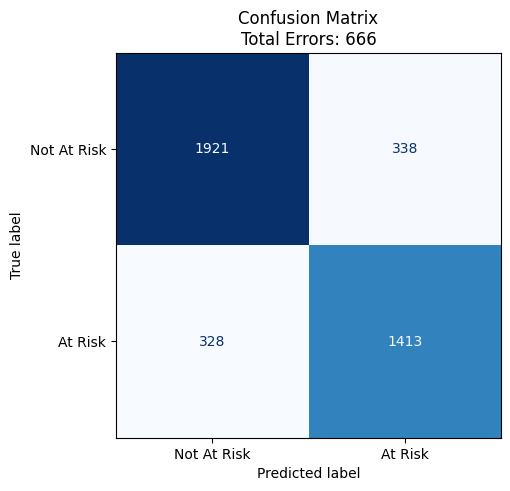

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
total_errors = (y_test != y_pred).sum()
labels = ['Not At Risk', 'At Risk']

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap='Blues', colorbar=False, ax=ax)

plt.title(f"Confusion Matrix\nTotal Errors: {total_errors}")
plt.show()

Model correctly predicted 1921 students not at risk (true negatives)

Model correctly predicted 1413 students at risk (true positves)

Model incorrectly predicted 338 students at risk (false positives). (These students actually passed)

Model incorrectly predicted 328 students not at risk (false negatives). (These students actually failed)